In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cv2
import skimage
from PIL import ImageFont, ImageDraw, Image

%matplotlib inline

In [44]:
from image_processing.process import find_table_and_bottom, extract_table_boxes, extract_blocks 
from image_processing.utils import *

In [45]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%autoreload 2

In [47]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [48]:
IMG_PATH = 'images/ex1.jpg'
# IMG_PATH = 'images/photo_to_scan_aa.jpg'
# IMG_PATH = 'images/ex1.jpg'

In [49]:
img = Image.open(IMG_PATH).convert('L')
img_np = np.asarray(img)

In [50]:
# plt.imshow(img_np, cmap='gray')
# plt.show()

# Full pipeline

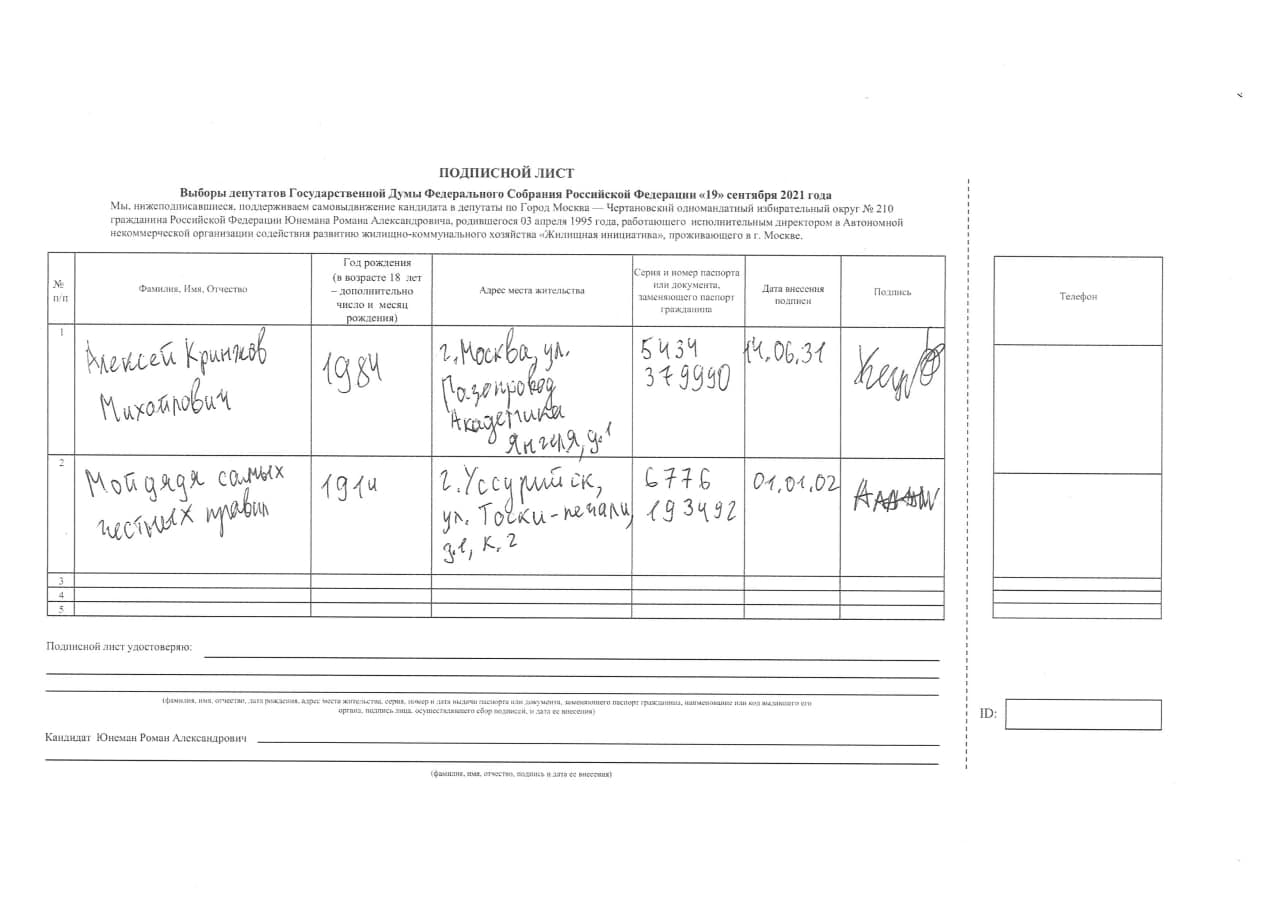

In [51]:
img

In [52]:
img.size

(1280, 905)

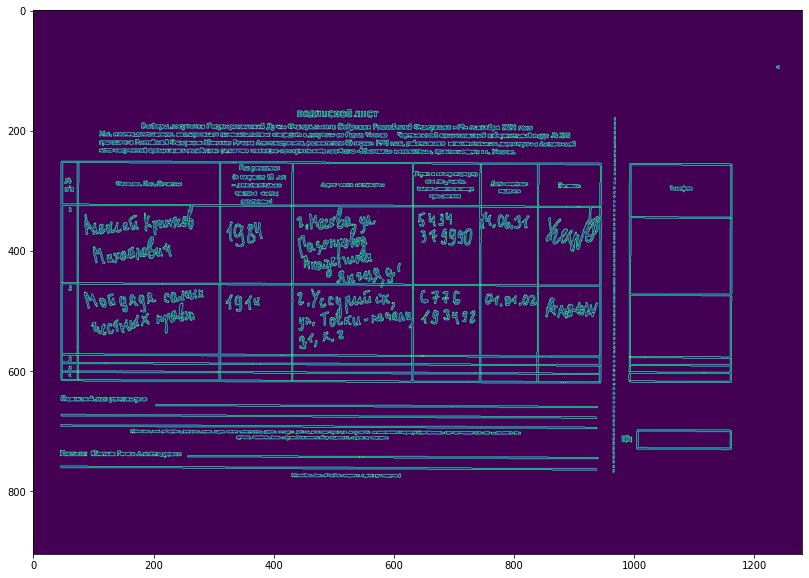

In [53]:
timg = cv2.GaussianBlur(np.array(img), (3, 3), 0)
edged =  cv2.Canny(timg, 10, 200)
plt.imshow(edged)

In [54]:
import imutils
from skimage.filters import threshold_local
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

4
cnt area 327055.5
img area 1158400
0.28233382251381217



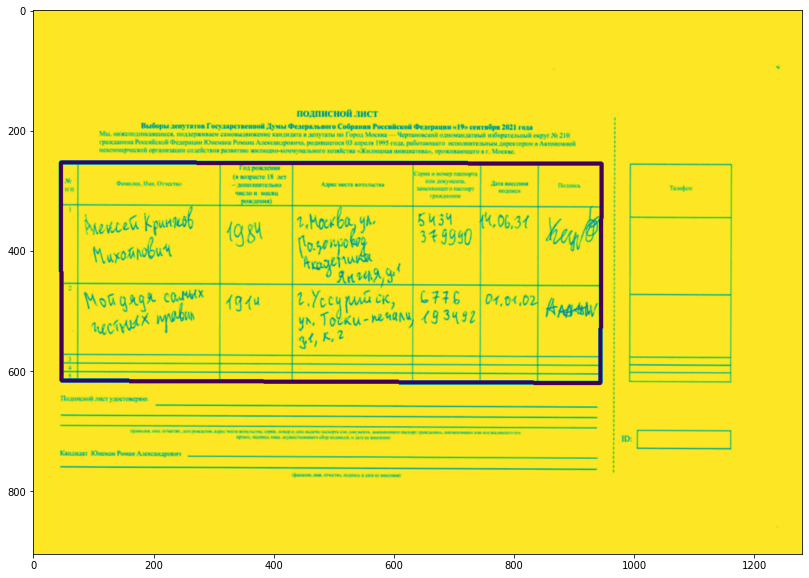

In [55]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
screenCnt = None
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    print(len(approx))
    
    img_area = timg.shape[0] * timg.shape[1]
    cnt_area = cv2.contourArea(c)
    if len(approx) == 4 and cnt_area <= 0.5 * img_area and cnt_area >= 0.2 * img_area:
        screenCnt = approx
        break
# show the contour (outline) of the piece of paper
print('cnt area', cv2.contourArea(screenCnt))
print('img area', (timg.shape[0] * timg.shape[1]))
print(cv2.contourArea(screenCnt) / (timg.shape[0] * timg.shape[1]))
print()
timg2 = np.array(timg)
cv2.drawContours(timg2, [screenCnt], -1, 0, 5)
plt.imshow(timg2)
plt.show()

STEP 3: Apply perspective transform


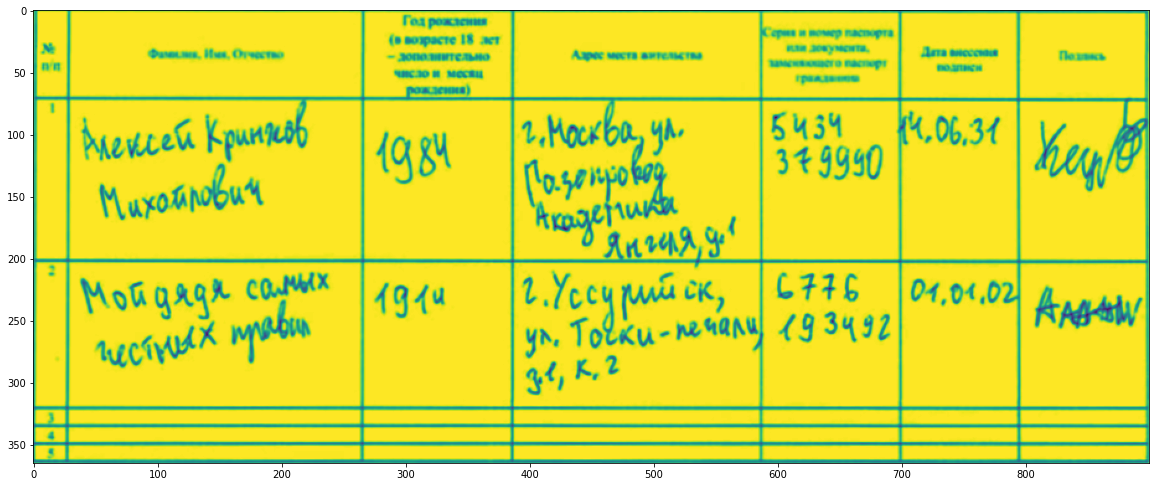

In [56]:
warped = four_point_transform(timg, screenCnt.reshape(4, 2))
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
# warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# T = threshold_local(warped, 11, offset = 10, method = "gaussian")
# warped = (warped > T).astype("uint8") * 255
# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt.imshow(warped)
plt.show()

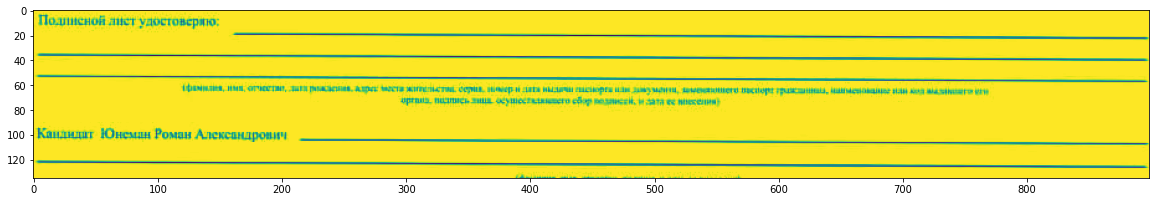

In [133]:
result = extract_blocks(np.array(img), debug=True)

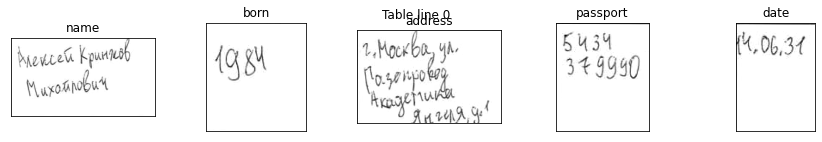

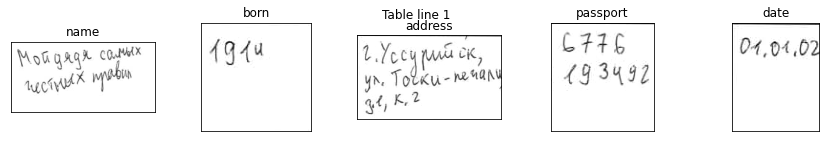

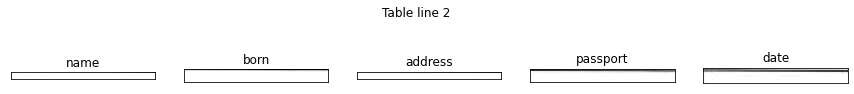

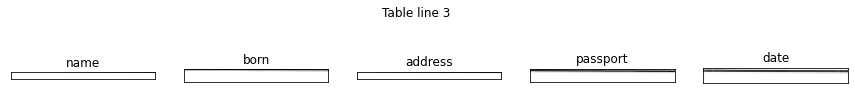

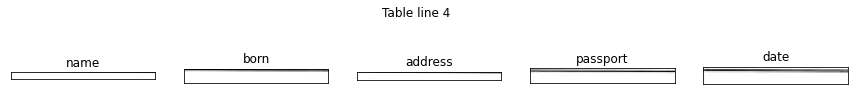

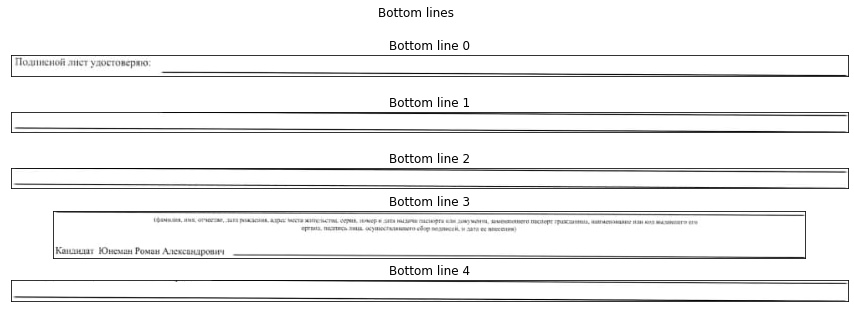

In [135]:
for i, line in enumerate(result['table_lines']):
    plt.figure(figsize=(15, 2))
    plt.suptitle(f'Table line {i}')
    for j, (key, cell_img) in enumerate(line.items()):
        plt.subplot(1, 5, j+1)
        plt.imshow(cell_img, cmap=plt.cm.gray)
        plt.title(key)
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)


    plt.show()

plt.figure(figsize=(15, 5))
plt.suptitle(f'Bottom lines')
for i, line in enumerate(result['bottom_lines']):
    
    plt.subplot(5, 1, i+1)
    plt.imshow(line, cmap=plt.cm.gray)
    plt.title(f'Bottom line {i}')
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)
plt.show()

# Pytesseract

In [137]:
# https://tesseract-ocr.github.io/tessdoc/Installation.html
from image_processing.tesseract_ocr import *

нес Кри Лихо, 4


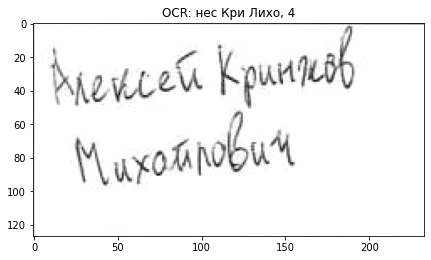

4


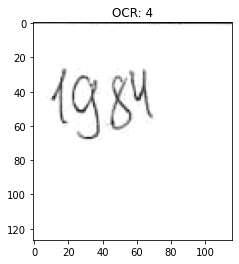

Мо иПон раА и


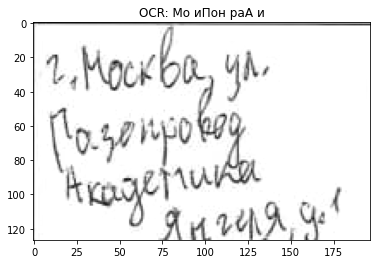

5ц3ч349940


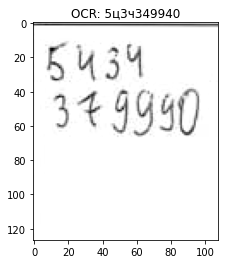

ЗН


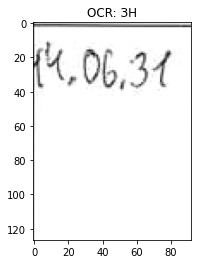

In [140]:
lines = result['table_lines']
for key in lines[0].keys():
    recognized = img_to_string(lines[0][key])
    print(recognized)
    plt.figure(figsize=(7, 4))
    plt.title(f'OCR: {recognized}')
    plt.imshow(lines[0][key], cmap=plt.cm.gray)
    plt.show()

Подлисной лист удостоверяю


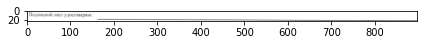

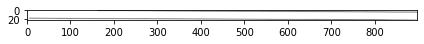

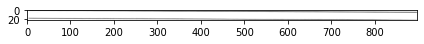

Канамдат Юнема Роман Алексин и


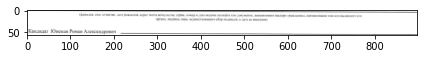

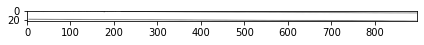

In [141]:
for line_img in result['bottom_lines']:
    recognized = img_to_string(line_img)
    print(recognized)
    plt.figure(figsize=(7, 4))
    plt.imshow(line_img, cmap=plt.cm.gray)
    plt.show()